<a href="https://www.kaggle.com/code/arunachal/gcp-basic-data-engineering-workflows-2?scriptVersionId=179989468" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Basic Data Engineering Workflows on Google Cloud Platform - Part 2

#### Here we continue the basic data engineering workflows on GCP from the previous notebook [here](https://www.kaggle.com/code/arunachal/gcp-basic-data-engineering-workflows): 

#### These lead to the final Workflow 9: Create an ETL pipeline for a financial dataset from MSSQL server (hosted on AWS) to BigQuery table

### Tools: 

#### **GCP**: Deployment Manager, Dataproc, Composer, Dataflow, PubSub, Cloud Functions, Compute (VM), BigQuery, GCS

#### **External**: MSSQL Server, SSMS, AWS-RDS, 

#### **Frameworks**: Apache NiFi, PySpark, Jinja

#### *Standard templates are customized for project needs at various steps.*

##### Credits for standard templates:   
a. GCP Documentations  
b. https://www.projectpro.io/

## Workflow 7: Filter and branch data using Beam Job (local to local)

#### 1. Customize the Beam Job below to read a local CSV, filter and aggregate data, and to push it back to local folder. 

In [ ]:
import apache_beam as beam

pipeline1 = beam.Pipeline()

airline_count = (
 pipeline1
 |beam.io.ReadFromText('/home/arunachal/Programming/Cloud/GCP/GCP Projects/GCP Project-Build Pipeline using Dataflow Apache Beam Python/Data/flights_data/flights_sample.csv')
 |beam.Map(lambda line: line.split(','))
 |beam.Filter(lambda line: line[0] == '2015')
 |beam.Map(lambda line: (line[4], 1))
 |beam.CombinePerKey(sum)
 |beam.io.WriteToText('/home/arunachal/Programming/Cloud/GCP/GCP Projects/GCP Project-Build Pipeline using Dataflow Apache Beam Python/Data/flights_data/flights_sample_output.csv')
 )

pipeline1.run()

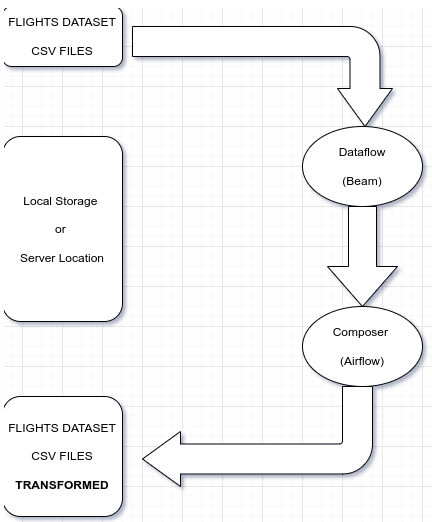

#### Run the pipeline to find transformed data populated in the local folder.

python3 Codes/pipeline_demo.py

#### 2. Next, we customize a multi-level Beam Job which in addition to filtering and aggregating, also branches the dataset.

In [ ]:
import apache_beam as beam

branched_pipeline = beam.Pipeline()
input_collection = (
 branched_pipeline
 | "Read from text file" >> beam.io.ReadFromText('/home/arunachal/Programming/Cloud/GCP/GCP Projects/GCP Project-Build Pipeline using Dataflow Apache Beam Python/Data/flights_data/flights_sample.csv')
 | "Split rows" >> beam.Map(lambda line: line.split(',')))

flight_month1 = (input_collection
 | 'Retrieve month1 flights' >> beam.Filter( lambda line: line[1] == '1')
 | 'Pair them 1–1 for month1' >> beam.Map( lambda line: ("Month1, " +line[4], 1))
 | 'Aggregation Operations: Grouping & Summing1' >> beam.CombinePerKey(sum))
flight_month2 = (input_collection
 |'Retrieve month2 flights' >> beam.Filter( lambda line: line[1] == '2')
 |'Pair them 1–1 for month2' >> beam.Map( lambda line: ("Month2, " +line[4], 1))
 | 'Aggregation Operations: Grouping & Summing2' >> beam.CombinePerKey(sum))

output = (
 (flight_month1, flight_month2)
 | beam.Flatten()
 | beam.io.WriteToText('/home/arunachal/Programming/Cloud/GCP/GCP Projects/GCP Project-Build Pipeline using Dataflow Apache Beam Python/Data/flights_data/flights_sample_branched.csv') )

branched_pipeline.run()

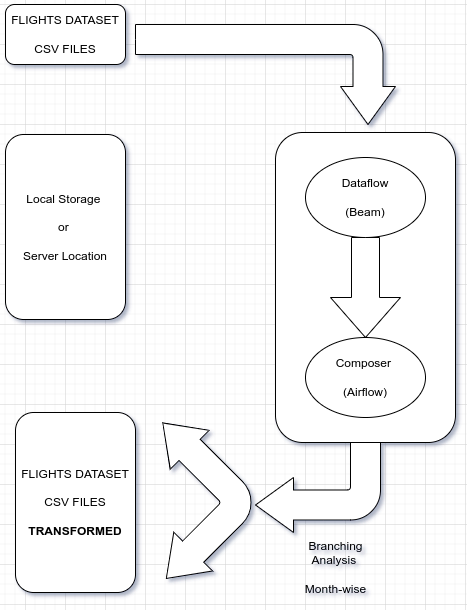

#### Run the pipeline to find transformed data populated in the local folder.

python3 Codes/branched_pipeline.py

## Workflow 8: Create a Beam Job to process both stream and batch datasets from local server to a BigQuery table.


#### The stream job involves PubSub with a publishing script while the batch job involves movement through GCS buckets. 

#### We implement the Beam Job for stream and batch datasets through a Dataflow runner orchestrated on Composer.

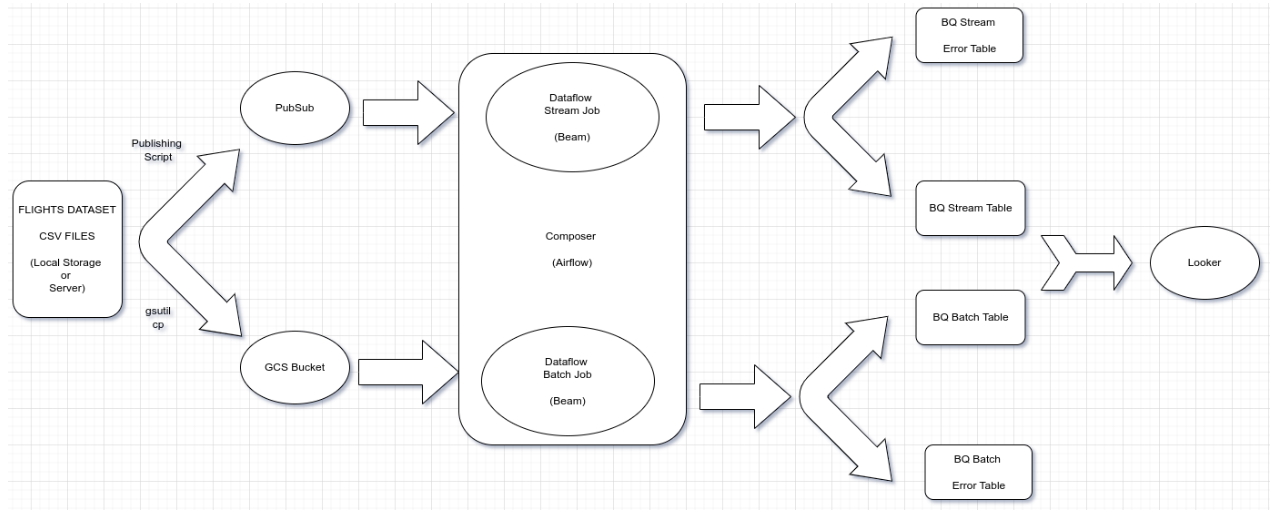

#### 1. Create a PubSub topic and a subscription to push stream data from local.

gcloud pubsub topics create flights  
gcloud pubsub subscriptions create flights-sub --topic flights

#### 2. Customize the configuration file below to aid the publishing script.

[gcp]  
project_id = gcloud-etl-422807  
topic_id = flights  
credentials_path = /home/arunachal/Programming/Cloud/GCP/key.json  
file_path = /home/arunachal/Programming/Cloud/GCP/GCP Projects/GCP Project-Build Pipeline using Dataflow Apache Beam   Python/Data/flights_data/flights_sample.csv  

#### 3. Customize the publishing template below.

In [ ]:
# -*- coding: utf-8 -*-

import time  # ,os,json
import argparse
from google.cloud import pubsub_v1
from google.oauth2 import service_account
from configparser import ConfigParser


def get_callback(f, data):
    def callback(f):
        try:
            print(f.result())
            futures.pop(data)
        except:  # noqa
            print("Please handle {} for {}.".format(f.exception(), data))

    return callback

def remove_quote_for_int_values(obj):
    if isinstance(obj, list):
        return [remove_quote_for_int_values(el) for el in obj]
    elif isinstance(obj, dict):
        result = {}
        for key, value in obj.items():
            if isinstance(value, dict) or isinstance(value, list):
                result[key] = remove_quote_for_int_values(value)
            else:
                try:
                    if value == '' and key != 'CANCELLATION_REASON':
                        value = 0
                    value = int(value)  # or any desired type
                except ValueError:  # TypeError when converting to `int`
                    pass
                result[key] = value
        return result
    else:
        return obj

def publish(filepath):
    with open(filepath, encoding="utf8") as openfileobject:
        for i,line in enumerate(openfileobject):
            if i==0:
                global keys
                keys = line.replace('\n','').split(',')
            else:
                data = str(remove_quote_for_int_values(dict(zip(keys, line.replace('\n','').split(',')))))
                #print(data)
                #data = line
                futures.update({data: None})
                # When you publish a message, the client returns a future.
                future = publisher.publish(topic=topic_path, data=data.encode("utf-8"))
                futures[data] = future
                # Publish failures shall be handled in the callback function.
                future.add_done_callback(get_callback(future, data))

    # Wait for all the publish futures to resolve before exiting.
    while futures:
        time.sleep(5)

    print("Published messages with error handler to " + topic_path)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--config_path', required=True,
        help='Config path from where config will be read.')
    args = parser.parse_args()
    # print(args.config_path)
    config = ConfigParser()
    config.read(args.config_path)
    # print (config.get('gcp','credentials_path'))

    credentials = service_account.Credentials.from_service_account_file(
        config.get('gcp', 'credentials_path'))

    # TODO(developer)
    project_id = config.get('gcp', 'project_id')
    topic_id = config.get('gcp', 'topic_id')

    publisher = pubsub_v1.PublisherClient(credentials=credentials)
    topic_path = publisher.topic_path(project_id, topic_id)
    futures = dict()
    publish(config.get('gcp', 'file_path'))

#### 4. Stream the data from local to PubSub.

python3 publish_csv_2_pubsub.py --config_path=/home/arunachal/Programming/Cloud/GCP/GCP\ Projects/GCP\ Project-Build\ Pipeline\ using\ Dataflow\ Apache\ Beam\ Python/Installation\ and\ Execution/config/publish_config.ini

#### 5. Customize the Python template below to create a Dataflow job which reads stream data from PubSub and outputs it as a BigQuery table.

In [ ]:
# -*- coding: utf-8 -*-

"""An Apache Beam streaming pipeline example.
It reads JSON encoded messages from Pub/Sub, transforms the message data and
writes the results to BigQuery.
"""

import argparse
import json,ast
import logging
#import time
from apache_beam.io.gcp.bigquery_tools import RetryStrategy
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from google.cloud import bigquery
#from apache_beam.options.pipeline_options import SetupOptions
#import apache_beam.transforms.window as window

# Defines the BigQuery schema for the output table.


schema=','.join([
        'YEAR:INTEGER',
        'MONTH:INTEGER',
        'DAY:INTEGER',
        'DAY_OF_WEEK:INTEGER',
        'AIRLINE:STRING',
        'FLIGHT_NUMBER:INTEGER',
        'TAIL_NUMBER:STRING',
        'ORIGIN_AIRPORT:STRING',
        'DESTINATION_AIRPORT:STRING',
        'SCHEDULED_DEPARTURE:INTEGER',
        'DEPARTURE_TIME:INTEGER',
        'DEPARTURE_DELAY:INTEGER',
        'TAXI_OUT:INTEGER',
        'WHEELS_OFF:INTEGER',
        'SCHEDULED_TIME:INTEGER',
        'ELAPSED_TIME:INTEGER',
        'AIR_TIME:INTEGER',
        'DISTANCE:INTEGER',
        'WHEELS_ON:INTEGER',
        'TAXI_IN:INTEGER',
        'SCHEDULED_ARRIVAL:INTEGER',
        'ARRIVAL_TIME:INTEGER',
        'ARRIVAL_DELAY:INTEGER',
        'DIVERTED:INTEGER',
        'CANCELLED:INTEGER',
        'CANCELLATION_REASON:STRING',
        'AIR_SYSTEM_DELAY:INTEGER',
        'SECURITY_DELAY:INTEGER',
        'AIRLINE_DELAY:INTEGER',
        'LATE_AIRCRAFT_DELAY:INTEGER',
        'WEATHER_DELAY:INTEGER',
])
ERROR_SCHEMA = ','.join([
    'error:STRING',
])


class ParseMessage(beam.DoFn):
    OUTPUT_ERROR_TAG = 'error'
    def process(self, line):
        """
        Extracts fields from json message
        :param line: pubsub message
        :return: have two outputs:
            - main: parsed data
            - error: error message
        """
        try:
            #row = json.dumps(line)
            parsed_row = ast.literal_eval(line) # parse json message to corresponding bgiquery table schema
            logging.info("Running")
            yield parsed_row

        except Exception as error:
            #print("error")
            logging.info("error")
            error_row = { 'error': str(error) }
            yield beam.pvalue.TaggedOutput(self.OUTPUT_ERROR_TAG, error_row)



def run(args, input_subscription, output_table, output_error_table):
    """Build and run the pipeline."""
    options = PipelineOptions(args, save_main_session=True, streaming=True)

    with beam.Pipeline(options=options) as pipeline:
        # Read the messages from PubSub and process them.
        rows, error_rows = (
            pipeline
            | 'Read from Pub/Sub' >> beam.io.ReadFromPubSub(
                subscription=input_subscription).with_output_types(bytes)
            | 'UTF-8 bytes to string' >> beam.Map(lambda msg: msg.decode('utf-8'))
            | 'Parse JSON messages' >> beam.ParDo(ParseMessage()).with_outputs(ParseMessage.OUTPUT_ERROR_TAG,
                                                                                main='rows')
             )
            #| 'Add URL keys' >> beam.Map(lambda msg: (msg['url'], msg))
            #| 'Group by URLs' >> beam.GroupByKey()
            #| 'Get statistics' >> beam.Map(get_statistics))

        # Output the results into BigQuery table.
        _ = (rows | 'Write to BigQuery'
             >> beam.io.WriteToBigQuery(output_table,
                                        schema=schema,
                                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                                        insert_retry_strategy=RetryStrategy.RETRY_ON_TRANSIENT_ERROR
                                        )
             )

        _ = (error_rows | 'Write errors to BigQuery'
             >> beam.io.WriteToBigQuery(output_error_table,
                                        schema=ERROR_SCHEMA,
                                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                                        insert_retry_strategy=RetryStrategy.RETRY_ON_TRANSIENT_ERROR
                                        )
             )


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--input_subscription', required=True,
        help='Input PubSub subscription of the form "/subscriptions/<PROJECT>/<SUBSCRIPTION>".')
    parser.add_argument(
        '--output_table', required=True,
        help='Output BigQuery table for results specified as: PROJECT:DATASET.TABLE or DATASET.TABLE.')
    parser.add_argument(
        '--output_error_table', required=True,
        help='Output BigQuery table for errors specified as: PROJECT:DATASET.TABLE or DATASET.TABLE.')
    known_args, pipeline_args = parser.parse_known_args()
    run(pipeline_args, known_args.input_subscription, known_args.output_table, known_args.output_error_table)

#### 6. Run the Python script above with Dataflow parameters to transfer data from PubSub to a BigQuery table.


python3 Codes/flights_stream_dataflow.py --input_subscription projects/gcloud-etl-422807/subscriptions/flights-sub --output_table newsoc_test_data.flights_batch --output_error_table newsoc_test_data.flights_batch_error --runner DataflowRunner --project gcloud-etl-422807 --region us-west1 --service_account_email gcloud-etl-service-account@gcloud-etl-422807.iam.gserviceaccount.com --staging_location gs://flights-dataflow/staging --temp_location gs://flights-dataflow/temp --job_name flights-pubsub-to-bq --num_workers 1 --max_num_workers 2

#### 7. Create a GCS bucket and transfer batch data from local to the GCS bucket.

gcloud storage buckets create gs://newsoc-test-data  
gsutil -m cp flights_sample.csv gs://newsoc-test-data

#### 8. Customize the Python template below to create a Dataflow job which reads batch data from GCS and outputs it as a BigQuery table.

In [ ]:
# -*- coding: utf-8 -*-


"""An Apache Beam batch pipeline example.
It reads JSON encoded messages from GCS file, transforms the message data and
writes the results to BigQuery.
"""

import argparse
import json
import logging
# import time
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions

# from apache_beam.options.pipeline_options import SetupOptions
# import apache_beam.transforms.window as window

# Defines the BigQuery schema for the output table.
schema=','.join([
        'YEAR:INTEGER',
        'MONTH:INTEGER',
        'DAY:INTEGER',
        'DAY_OF_WEEK:INTEGER',
        'AIRLINE:STRING',
        'FLIGHT_NUMBER:INTEGER',
        'TAIL_NUMBER:STRING',
        'ORIGIN_AIRPORT:STRING',
        'DESTINATION_AIRPORT:STRING',
        'SCHEDULED_DEPARTURE:INTEGER',
        'DEPARTURE_TIME:INTEGER',
        'DEPARTURE_DELAY:INTEGER',
        'TAXI_OUT:INTEGER',
        'WHEELS_OFF:INTEGER',
        'SCHEDULED_TIME:INTEGER',
        'ELAPSED_TIME:INTEGER',
        'AIR_TIME:INTEGER',
        'DISTANCE:INTEGER',
        'WHEELS_ON:INTEGER',
        'TAXI_IN:INTEGER',
        'SCHEDULED_ARRIVAL:INTEGER',
        'ARRIVAL_TIME:INTEGER',
        'ARRIVAL_DELAY:INTEGER',
        'DIVERTED:INTEGER',
        'CANCELLED:INTEGER',
        'CANCELLATION_REASON:STRING',
        'AIR_SYSTEM_DELAY:INTEGER',
        'SECURITY_DELAY:INTEGER',
        'AIRLINE_DELAY:INTEGER',
        'LATE_AIRCRAFT_DELAY:INTEGER',
        'WEATHER_DELAY:INTEGER',
        'AIRLINE_NAME:STRING',
])
ERROR_SCHEMA = ','.join([
    'error:STRING',
])

class ParseMessage(beam.DoFn):
    OUTPUT_ERROR_TAG = 'error'

    def process(self, element, side_input,table):
        """
        Extracts fields from csv message
        :param element: line of file read from input gcs location.
        :return: have two outputs:
            - parsed data: parsed flights data with airline information
            - error data: error data
        """
        try:
            col_list = ['YEAR','MONTH','DAY','DAY_OF_WEEK','AIRLINE','FLIGHT_NUMBER','TAIL_NUMBER','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE','DEPARTURE_TIME','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF','SCHEDULED_TIME','ELAPSED_TIME','AIR_TIME','DISTANCE','WHEELS_ON','TAXI_IN','SCHEDULED_ARRIVAL','ARRIVAL_TIME','ARRIVAL_DELAY','DIVERTED','CANCELLED','CANCELLATION_REASON','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
            #row = json.dumps(line)
            csv_element_list = element.replace('\n','').split(',') # parse csv line to corresponding bgiquery table schema
            final_dict = dict(zip(col_list,csv_element_list))
            logging.info("Running")
            print(side_input)
            final_dict['AIRLINE_NAME'] = side_input[csv_element_list[4]]
            yield final_dict

        except Exception as error:
            #print("error")
            logging.info("error")
            print(str(error))
            error_row = { 'error': str(error) }
            yield beam.pvalue.TaggedOutput(self.OUTPUT_ERROR_TAG, error_row)


class DataflowOptions(PipelineOptions):

    @classmethod
    def _add_argparse_args(cls, parser):
        parser.add_value_provider_argument(
            '--input_path', type=str, default='gs://newsoc-test-data/flights_sample.csv',
            help='Input GCS path from where files will be read.')
        parser.add_value_provider_argument(
            '--side_input_path', type=str, default='gs://newsoc-test-data/airlines.csv',
            help='Input GCS path from where side input files will be read.')
        parser.add_value_provider_argument(
            '--table', type=str, default='newsoc-test-data.flights_batch',
            help='Output BigQuery table for file specified as: PROJECT:DATASET.TABLE or DATASET.TABLE.')
        parser.add_value_provider_argument(
            '--error_table', type=str, default='newsoc-test-data.flights_batch_error',
            help='Output BigQuery table for error as: PROJECT:DATASET.TABLE or DATASET.TABLE.')


def run(argv=None):
    """Build and run the pipeline."""
    parser = argparse.ArgumentParser(argv)
    known_args, pipeline_args = parser.parse_known_args()
    options = PipelineOptions(pipeline_args, save_main_session=True)
    dataflow_options = options.view_as(DataflowOptions)
    with beam.Pipeline(options=options) as pipeline:
        print(str(dataflow_options.side_input_path))
        print("dome")
        side_input_airline = pipeline | 'Read airline messages' >> beam.io.ReadFromText(dataflow_options.side_input_path) \
                                      | beam.Map(lambda record: ('%s' % record.split(',')[0], '%s' % record.split(',')[1]))

                                      #| beam.Map(lambda record: {record.split(',')[0]:record.split(',')[1]})
        rows, error = (
                pipeline
                | 'Read CSV messages' >> beam.io.ReadFromText(dataflow_options.input_path,skip_header_lines=1)
                | 'Parse CSV messages' >> beam.ParDo(ParseMessage(), beam.pvalue.AsDict(side_input_airline),dataflow_options.table).with_outputs(
            ParseMessage.OUTPUT_ERROR_TAG,
            main='rows')
        )

        # Output the results into BigQuery table.
        _ = (rows | 'Write rows to BigQuery'
             >> beam.io.WriteToBigQuery(table=dataflow_options.table,
                                        schema=schema,
                                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                                        # insert_retry_strategy=RetryStrategy.RETRY_ON_TRANSIENT_ERROR
                                        )
             )

        _ = (error | 'Write error to BigQuery'
             >> beam.io.WriteToBigQuery(table=dataflow_options.error_table,
                                        schema=ERROR_SCHEMA,
                                        create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                                        write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
                                        # insert_retry_strategy=RetryStrategy.RETRY_ON_TRANSIENT_ERROR
                                        )
             )


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()

#### 9. Run the Python script above with Dataflow parameters to transfer data from GCS to a BigQuery table.


python3 Codes/flights_batch_templated.py --input_path gs://newsoc-test-data/flights_sample.csv --side_input_path gs://newsoc-test-data/airlines.csv --table newsoc_test_data.flights_batch --error_table newsoc_test_data.flights_batch_error --runner DataflowRunner --project gcloud-etl-422807 --region us-west1 --service_account_email gcloud-etl-service-account@gcloud-etl-422807.iam.gserviceaccount.com --staging_location gs://flights-dataflow/staging --temp_location gs://flights-dataflow/temp --job_name flights-batch-gcs-to-bq --num_workers 1 --max_num_workers 2

#### 10. A stream and a batch tables alongside their respective error tables can now be seen on BigQuery for query and visualization.

## Workflow 9: Create an ETL pipeline of financial data from MS-SQL Server to GCP using Dataproc, Deployment Manager, Apache Nifi, and PySpark

### Tools: 

**GCP**: Deployment Manager, Dataproc, Cloud Functions, Compute (VM), BigQuery, GCS

**External**: MSSQL, AWS-RDS, SSMS

**Frameworks**: Apache NiFi, PySpark, SQL, Jinja

#### Below we create a pipeline for a financial dataset involving these broad steps.

a. Ingest dataset from Stock Exchange APIs into an MSSQL server on AWS-RDS and managed locally through SQL Server Management Studio (SSMS)  
b. Deploy cloud infrastructure for ETL job as a code (IaC) using Deployment Manager  
c. Transfer dataset from MSSQL server into a GCS bucket using Apache Nifi running on a VM  
d. Transform dataset using PySpark on a Dataproc cluster auto-created by a cloud function trigger  
e. Load processed dataset into BQ using the same cloud function for query and insights  

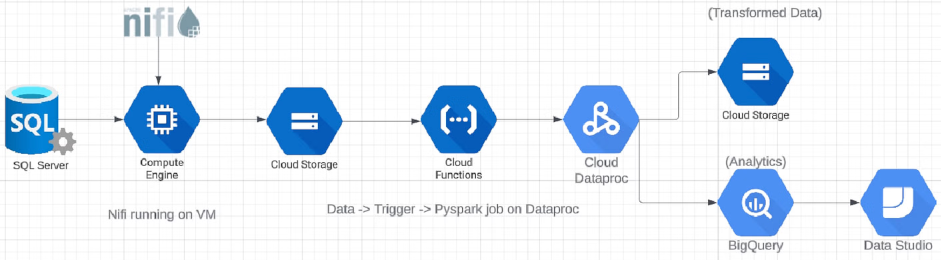

#### 1. Download the dataset by selecting appropriate filters here: https://www.bseindia.com/markets/equity/EQReports/StockPrcHistori.html?flag=0


#### 2. Create an MSSQL server on AWS-RDS with credentials and copy the generated endpoint.

aws rds create-db-instance --db-instance-identifier mssql-etl-gcp --db-instance-class db.m5.large --engine sqlserver-se --master-username admin --master-user-password <*****>

**Endpoint**: mssql-etl-gcp.c1yeyuauigzt.ap-south-1.rds.amazonaws.com, 1433

Add a new inbound firewall rule in the default VPC security group to allow custom TCP connection from local public IP as xx.xx.xx.xxx:32.

#### 3. Set up a new connection in SSMS using above endpoint and credentials. 

#### Create a new dataset mssql-gcp and import CSV file using the wizard: Tasks > Import Data > Flat File. Specify MSSQL database credentials and destination as SQL Server Native Client.

#### Add an id column to the table:

ALTER TABLE mssql-gcp.dbo.financial_data add id int not null identity(1,1)

#### 4. Customise the jinja templates below for Deployment Manager to create (a) GCS buckets (b) VM instance (c) BQ output tables.

In [ ]:
# gcs.jinja

{% set INPUT_BUCKET_NAME = env['project'] + '-etl-input' %}
{% set RESOURCES_BUCKET_NAME = env['project'] + '-etl-resources' %}

resources:
- type: gcp-types/storage-v1:buckets
  name: {{ INPUT_BUCKET_NAME }}
  properties:
    predefinedAcl: projectPrivate
    projection: full
    location: US
    storageClass: STANDARD

- type: gcp-types/storage-v1:buckets
  name: {{ RESOURCES_BUCKET_NAME }}
  properties:
    predefinedAcl: projectPrivate
    projection: full
    location: US
    storageClass: STANDARD   

In [ ]:
# vm.jinja

{% set VM_NAME = env['project'] + '-etl-vm' %}

resources:
- type: compute.v1.instance
  name: {{ VM_NAME }}
  properties:
    zone: {{ properties["zone"] }}
    machineType: https://www.googleapis.com/compute/v1/projects/{{ env['project'] }}/zones/{{ properties["zone"] }}/machineTypes/{{ properties["machineType"] }}
    tags:
        items: ["http-server","https-server"]
    disks:
    - deviceName: boot
      type: PERSISTENT
      boot: true
      autoDelete: true
      initializeParams:
        sourceImage: https://www.googleapis.com/compute/v1/projects/ubuntu-os-cloud/global/images/family/ubuntu-2004-lts
    networkInterfaces:
    - network: https://www.googleapis.com/compute/v1/projects/{{ env['project'] }}/global/networks/default
      # Access Config required to give the instance a public IP address
      accessConfigs:
      - name: External NAT
        type: ONE_TO_ONE_NAT
# This is to enable or disable firewall
- name: default-allow-http
  type: compute.v1.firewall
  properties:
    network: https://www.googleapis.com/compute/v1/projects/{{ env['project'] }}/global/networks/default
    targetTags: ["http-server","https-server"]
    sourceRanges: ["0.0.0.0/0"]
    allowed:
    - IPProtocol: TCP
      ports: ["80"]

In [ ]:
# bigquery.jinja

# Can't use deployment name as it is going to be filled in with a generated
# name which has dashes in it, which are not valid bigquery name characters.
{% set DATASET_NAME = (env['project'] + "-etl-dataset")|replace("-","_") %}
{% set BQ_TABLE_NAME = "financial_data" %}


resources:
# Dataset Resource
- name: {{ DATASET_NAME }}
  type: gcp-types/bigquery-v2:datasets
  properties:
    datasetReference:
      datasetId: {{ DATASET_NAME }}
      description: The {{ DATASET_NAME }} dataset contains all the tables for bq etl pipeline.
      location: US

# Employee Table
- name: {{ BQ_TABLE_NAME }}
  type: gcp-types/bigquery-v2:tables
  properties:
    datasetId: $(ref.{{ DATASET_NAME }}.datasetReference.datasetId)
    tableReference:
      tableId: {{ BQ_TABLE_NAME }}
    schema:
          fields:
          - name: id
            type: INTEGER
            mode: NULLABLE
          - name: Symbol
            type: STRING
            mode: NULLABLE
          - name: Date
            type: date
            mode: NULLABLE
          - name: Open_Price
            type: FLOAT
            mode: NULLABLE
          - name: High_Price
            type: FLOAT
            mode: NULLABLE
          - name: Low_Price
            type: FLOAT
            mode: NULLABLE
          - name: Close_Price
            type: FLOAT
            mode: NULLABLE
          - name: WAP
            type: FLOAT
            mode: NULLABLE
          - name: No_of_Shares
            type: INTEGER
            mode: NULLABLE
          - name: No_of_Trades
            type: INTEGER
            mode: NULLABLE
          - name: Total_Turnover
            type: FLOAT
            mode: NULLABLE
          - name: Deliverable_Quantity
            type: INTEGER
            mode: NULLABLE
          - name: Percentage_Deli_Qty_to_Traded_Qty
            type: FLOAT
            mode: NULLABLE
          - name: Spread_High_Low
            type: FLOAT
            mode: NULLABLE
          - name: Spread_Close_Open
            type: FLOAT
            mode: NULLABLE

#### 5. Customize the yaml config file below through which Deployment Manager instantiates above templates.

In [ ]:
imports:
 - path: vm.jinja
 - path: bigquery.jinja
 - path: gcs.jinja

resources:
- name: vm
  type: vm.jinja
  properties:
    zone: us-central1-a
    machineType: n2-standard-4
- name: gcs
  type: gcs.jinja
- name: bq
  type: bigquery.jinja"

In [ ]:
#### 6. Deploy specified resources using Deployment Manager and verify.

gcloud deployment-manager deployments create mssql-bq-etl-deployment --config finance_project_deployment.yaml

gcloud deployment-manager deployments describe mssql-bq-etl-deployment

#### 7. Open SSH shell from newly created VM and install Nifi.

sudo su  
apt update  
apt install openjdk-8-jdk  
wget https://archive.apache.org/dist/nifi/1.16.0/nifi-1.16.0-bin.tar.gz  

tar -xzvf nifi-1.16.0-bin.tar.gz  

#### 8. Modify the below parameters in Nifi's configuration file.

nano nifi-1.16.0/conf/nifi.properties

In [ ]:
#### nifi.properties configuration #### 
---------------------------------------

nifi.remote.input.http.enabled = false  

#### web properties ####
nifi.web.http.host=  
nifi.web.http.port=8088  

nifi.web.https.host=  
nifi.web.https.port=  

#### security properties ####
nifi.security.keystore=  
nifi.security.keystoreType=  
nifi.security.keystorePasswd=  
nifi.security.keyPasswd=  
nifi.security.truststore=  
nifi.security.truststoreType=  
nifi.security.truststorePasswd=  

#### 7. Create a new firewall rule in default VPC Network allowing TCP connections from local machine by specifying public IPv4 with port 8088.

gcloud compute firewall-rules create mssql-gcs-firewall --allow=tcp:8088 --source-ranges=xx.xx.xx.xxx

gcloud computer firewall-rules list

#### 8. Launch Nifi, monitor logs, copy external IP of the VM instance and open Nifi UI.

./nifi.sh start  
tail -100f nifi-app.log  
gcloud compute instances list  

**Open Nifi interface as:** External IP of VM Instance:8088/nifi  

#### 9. Create a process group MSSQL-GCP-ETL on Nifi. Within this, create 2 processors, linked by a connection.

#### Configure processors and connections as below.

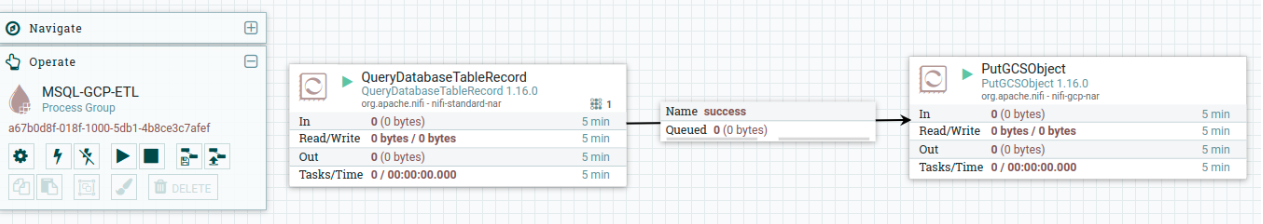

#### **Processor 1: queryDatabaseTablerecord**  

**Database Connection Pooling Service**: DBCP Connection Pool

#### Configure Controller Services for DBCPConnectionPool.

**Database Connection URL**: jdbc:sqlserver://mssql-etl-gcp.c1yeyuauigzt.ap-south1.rds.amazonaws.com;port=1433;database=mssql_gcp2;authentication=NotSpecified;encrypt=true;trustServerCertificate=true

**Database Driver Class Name**: com.microsoft.sqlserver.jdbc.SQLServerDriver

#### Install JDBC driver for MS-SQL Server from https://go.microsoft.com/fwlink/?linkid=2272720 and upload source file to Cloud Home through SSH terminal.

#### Specify location of the jre jar file as,

**Database Driver Location(s)**: /home/kumararunachal1/sqljdbc_12.6/enu/jars/mssql-jdbc-12.6.1.jre8.jar

#### Specify Database User and Password

**Database User**: admin  
**Password**: *******

**Database Type**: MS SQL 2012+  
**Table Name**: SampleData1

**Record Writer**: ParquetRecordSetWriter

#### Configure controller service as:

**Compression Type**: SNAPPY

**Maximum-value Columns**: id

#### **Connection 1 (between Processor 1 and Processor 2)** 

**Relationship**: Success

#### **Processor 2: PutGCSObject**

**Project ID**: gcloud-etl-422807
**GCP Credentials Provider Service**: GCPCredentialsControllerService

#### Configure controller service: GCPCredentialsControllerService

**Service Account JSON**: paste JSON from google service account key file

**Bucket**: gcloud-etl-422807-etl-input

**Key**: "insert_dt=${now():format("yyyy-MM-dd")}/${filename}"

#### Set Relationships as:

**failure**: terminate  
**success**: terminate

#### 10. Run the process group MSSQL-GCP-ETL. 

The two processors change their states.  
MSSQL database table SampleData1 is populated as a parquet file in the created bucket gs://gcloud-etl-422807-etl-input with date as a key (as per specified format above).

#### 11. Create a Cloud Function mssql-gcs-trigger-function. This function:

a. is triggered by any (parquet) file placed in the created bucket gs://gcloud-etl-422807-etl-input   
b. creates a temporary Dataproc cluster  
c. uses a PySpark job to transform the parquet file in the input bucket into the final BQ table  

#### 12. Customize the PySpark job template as below. This requires specifying a jar file. The correct version can be found using the steps shown here: https://github.com/tfayyaz/cloud-dataproc/blob/master/notebooks/python/1.2.%20BigQuery%20Storage%20%26%20Spark%20SQL%20-%20Python.ipynb

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *
import sys

# creating spark session
spark = SparkSession.builder \
.appName("gcs-to-bq") \
.config("spark.jars", "gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar") \
.getOrCreate()

# Reading the commnad line arguments
data_uri = sys.argv[1]
file_format = sys.argv[2]
partition_field = sys.argv[3]
project_id = sys.argv[4]
dataset_name = sys.argv[5]
table_name = sys.argv[6]
gcs_temp_bucket = sys.argv[7]

# creating bigquery table by concatinating the project_id and dataset_name and table_name
bigquery_table = f"{project_id}.{dataset_name}.{table_name}"


today = datetime.now().strftime("%Y-%m-%d")
print(today)
path = f"{data_uri}/{partition_field}={today}"
print(path)

# Reading the parquet files from GCS bucket, assigning the schema manually and converting the date to proper format

input_df = spark \
.read \
.option("recursiveFilelookup","True") \
.format(file_format) \
.option("header","True") \
.load(path) \
.withColumn("id", col('id').cast('int')) \
.withColumn("Symbol", col('Symbol').cast('string')) \
.withColumn("Date",to_date("Date", 'dd-MMM-yy')) \
.withColumn("Open_Price", col('Open_Price').cast('float')) \
.withColumn("High_Price", col('High_Price').cast('float')) \
.withColumn('Low_Price',col('Low_Price').cast('float')) \
.withColumn("Close_Price", col('Close_Price').cast('float')) \
.withColumn("WAP", col('WAP').cast('float')) \
.withColumn("No_of_Shares", col('No_of_Shares').cast('int')) \
.withColumn("No_of_Trades", col('No_of_Trades').cast('int')) \
.withColumn("Total_Turnover", col('Total_Turnover').cast('float')) \
.withColumn("Deliverable_Quantity", col('Deliverable_Quantity').cast('int')) \
.withColumn("Percentage_Deli_Qty_to_Traded_Qty", col('Percentage_Deli_Qty_to_Traded_Qty').cast('float')) \
.withColumn("Spread_High_Low", col('Spread_High_Low').cast('float')) \
.withColumn("Spread_Close_Open", col('Spread_Close_Open').cast('float'))


# Load the processed data from GCS location into a BigQuery table
input_df.write \
    .mode("append") \
    .format("com.google.cloud.spark.bigquery") \
    .option("temporaryGcsBucket", gcs_temp_bucket) \
    .option("table", bigquery_table) \
    .option("createDisposition", "CREATE_IF_NEEDED") \
    .option("writeDisposition", "WRITE_TRUNCATE") \
    .save()

#### Place the PySpark job file to the created resources bucket.

gsutil cp gsc_to_bq_test_v2.py gs://gcloud-etl-422807-etl-resources/

#### 13. Configure the Cloud Function as below

a. 1st Gen  
b. Trigger: Cloud Storage: gs://gcloud-etl-422807-etl-input  
c. Memory: 512 MB  
d. Timeout: 540 s  
e. Set runtime environment variable  

**main_python_file_uri**: gs://gcloud-etl-422807-etl-resources/gsc_to_bq_test_v2.py

f. Python 3.7 Runtime  
g. Requirements:

google-cloud-dataproc==3.0.0  
google-cloud-storage==1.42.2

#### 14. Customize the Cloud Function template below. 

In [ ]:
from google.cloud import dataproc_v1 as dataproc
from google.cloud import storage
import os
import logging
import json


def instantiate_inline_workflow_template(event, context):
    # Initialise clients
    storage_client = storage.Client()

    # Get variables
    project_id = os.environ.get("GCP_PROJECT")  
    region = os.environ.get("FUNCTION_REGION")  
    main_python_file_uri = os.environ.get(
        "main_python_file_uri") 
    input_file = f"gs://{event['bucket']}/{event['name']}"

    # Create a client with the endpoint set to the desired region.
    workflow_template_client = dataproc.WorkflowTemplateServiceClient(
        client_options={"api_endpoint": f"{region}-dataproc.googleapis.com:443"}
    )
    parent = f"projects/{project_id}/regions/{region}"

    template = {
        "jobs": [
            {
                "pyspark_job": {
                    "main_python_file_uri": main_python_file_uri,
                    "jar_file_uris": ["gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar"],
                    "args": ["gs://gcloud-etl-422807-etl-input",
                    "parquet",
                    "insert_dt", 
                    "gcloud-etl-422807", 
                    "gcloud_etl_422807_etl_dataset",
                    "financial_data",
                    "gs://gcloud-etl-422807-etl-resources/"],
                },
                "step_id": "pyspark_etl",
            },
        ],
        "placement": {
            "managed_cluster": {
                "cluster_name": "cluster-d02b",
                "config": {
                    "gce_cluster_config": {"zone_uri": ""},
                    "master_config": {"num_instances": 1, "machine_type_uri": "e2-standard-2"},
                    "worker_config": {"num_instances": 0, "machine_type_uri": "e2-standard-2"},
                    "software_config": {"image_version": "2.2-debian"},
                },
            }
        },
    }

    logging.info(
        f"Creating temporary dataproc cluster to run pyspark job on {input_file} and extract result to")

    operation = workflow_template_client.instantiate_inline_workflow_template(
        request={"parent": parent, "template": template}
    )
    operation.result()
    logging.info("Workflow ran successfully.")

#### Specify Entry Point: instantiate_inline_workflow_template

#### Author and deploy the Cloud Function.

#### 15. Clear the state of Processor 1 on Nifi. Run the Process Group. 

The dataset from MSSQL server populates into input bucket as a parquet file with date in the folder name. 

Cloud Function is triggered which creates a Dataproc cluster to run the PySpark job. 

The PySpark job runs and outputs data into the specified table on BQ, ready for query and visualization.